<a href="https://colab.research.google.com/github/iiCellxx/CSEL-303/blob/main/Task4_ALMARIO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cel Rick D. Almario From BSCS3B

Task 4: Smart Grid Simulation Using Multiple Models

Scenario:

Simulate a smart grid, where:

Power generation (renewables, thermal plants) is modeled using continuous equations.

Consumer demand follows stochastic discrete events (e.g., appliances turning on/off).

• Grid control decisions (e.g., load shedding) are implemented using rule-based logic.

Steps:

1. Model power generation as continuous differential equations.

2. Implement stochastic consumer demand using random events in Python/SimPy.

3. Integrate control logic for grid stability.

4. Run simulations and compare different grid control strategies.

# Step 1: Install and Import Required Libraries

In [1]:
!pip install simpy

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import simpy
from scipy.integrate import odeint
import random

# Step 2: Model Power Generation as Continuous Equations

Define Power Generation Model

In [3]:
def power_generation(y, t, P_solar_max, P_wind_max, P_thermal, alpha_solar, alpha_wind):
    """
    Defines the continuous power generation model using differential equations.

    Parameters:
        y (list): Current power output [Solar, Wind]
        t (float): Time step
        P_solar_max (float): Maximum solar power output
        P_wind_max (float): Maximum wind power output
        P_thermal (float): Constant power from thermal plants
        alpha_solar (float): Solar generation variability factor
        alpha_wind (float): Wind generation variability factor

    Returns:
        dydt (list): Rate of change of solar and wind power
    """
    P_solar, P_wind = y
    dP_solar_dt = alpha_solar * (P_solar_max - P_solar) * np.sin(0.1 * t)
    dP_wind_dt = alpha_wind * (P_wind_max - P_wind) * np.cos(0.1 * t)

    return [dP_solar_dt, dP_wind_dt]


Solve the Power Generation Model

In [4]:
# Power generation parameters
P_solar_max = 100  # Max solar power (MW)
P_wind_max = 80    # Max wind power (MW)
P_thermal = 120    # Thermal plant power (MW) (constant)
alpha_solar = 0.05  # Variability of solar
alpha_wind = 0.07   # Variability of wind

# Initial conditions: Solar and wind power start at 50% of their max values
initial_conditions = [P_solar_max / 2, P_wind_max / 2]

# Time range
t = np.linspace(0, 24, 1000)  # Simulating 24 hours

# Solve ODE
solution = odeint(power_generation, initial_conditions, t, args=(P_solar_max, P_wind_max, P_thermal, alpha_solar, alpha_wind))

# Extract results
P_solar_output, P_wind_output = solution.T
P_total_output = P_solar_output + P_wind_output + P_thermal  # Total power available


# Step 3: Simulate Stochastic Consumer Demand

Define Consumer Demand Model Using SimPy

In [5]:
class ConsumerDemand:
    def __init__(self, env, demand_mean, demand_std, time_interval, grid):
        """
        Initializes the consumer demand process.

        Parameters:
            env (simpy.Environment): Simulation environment
            demand_mean (float): Average power demand (MW)
            demand_std (float): Demand variability
            time_interval (float): Frequency of demand updates (minutes)
            grid (GridControl): Grid control object to monitor demand
        """
        self.env = env
        self.demand_mean = demand_mean
        self.demand_std = demand_std
        self.time_interval = time_interval
        self.grid = grid
        self.process = env.process(self.update_demand())

    def update_demand(self):
        """Stochastically updates power demand every 'time_interval' minutes."""
        while True:
            demand_variation = np.random.normal(self.demand_mean, self.demand_std)
            self.grid.update_demand(demand_variation)
            yield self.env.timeout(self.time_interval)


Set Up Simulation Parameters

In [6]:
# Consumer demand parameters
demand_mean = 250  # MW
demand_std = 20    # MW variation
demand_update_interval = 5  # Demand updates every 5 minutes


# Step 4: Implement Rule-Based Grid Control

Define Grid Control System

In [7]:
class GridControl:
    def __init__(self, env, initial_demand, total_power):
        """
        Initializes the smart grid control system.

        Parameters:
            env (simpy.Environment): Simulation environment
            initial_demand (float): Initial power demand (MW)
            total_power (list): Power generation array from the continuous model
        """
        self.env = env
        self.total_power = total_power
        self.current_demand = initial_demand
        self.current_time_index = 0
        self.load_shedding_events = []
        self.process = env.process(self.monitor_grid())

    def update_demand(self, new_demand):
        """Updates consumer demand."""
        self.current_demand = new_demand

    def monitor_grid(self):
        """Monitors grid and applies load shedding if necessary."""
        while self.current_time_index < len(self.total_power):
            available_power = self.total_power[self.current_time_index]

            if self.current_demand > available_power:
                shed_amount = self.current_demand - available_power
                self.current_demand -= shed_amount
                self.load_shedding_events.append((self.env.now, shed_amount))
                print(f"🔴 Load shedding at t={self.env.now:.2f}h | {shed_amount:.2f} MW shed")

            self.current_time_index += 1
            yield self.env.timeout(0.1)  # Simulate in small steps


# Step 5: Run the Smart Grid Simulation

In [8]:
# Initialize simulation environment
env = simpy.Environment()

# Initialize grid control system
grid = GridControl(env, demand_mean, P_total_output)

# Initialize consumer demand process
consumer_demand = ConsumerDemand(env, demand_mean, demand_std, demand_update_interval, grid)

# Run simulation
env.run(until=24)  # Run for 24 hours


🔴 Load shedding at t=0.00h | 40.00 MW shed
🔴 Load shedding at t=0.10h | 56.53 MW shed
🔴 Load shedding at t=5.10h | 23.52 MW shed
🔴 Load shedding at t=10.10h | 36.16 MW shed
🔴 Load shedding at t=15.10h | 26.59 MW shed
🔴 Load shedding at t=20.00h | 53.50 MW shed


# Step 6: Analyze and Visualize Results

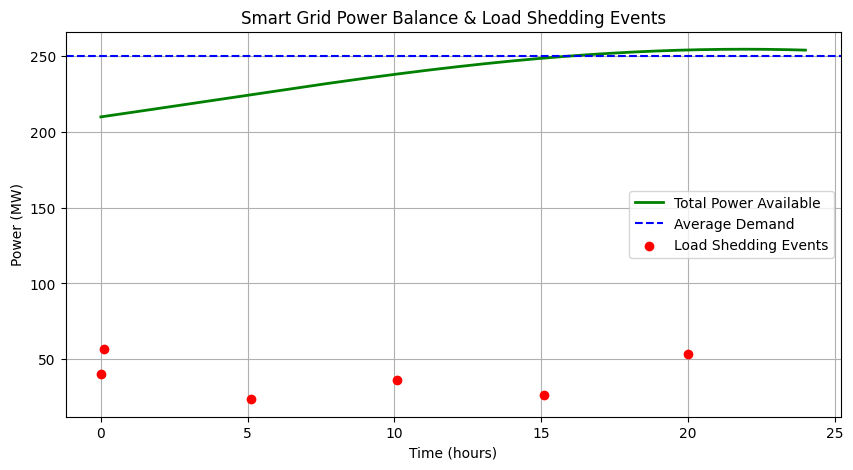

In [9]:
# Extract load shedding events
shedding_times, shedding_amounts = zip(*grid.load_shedding_events) if grid.load_shedding_events else ([], [])

# Plot Power Generation vs. Demand
plt.figure(figsize=(10, 5))
plt.plot(t, P_total_output, label="Total Power Available", color="green", linewidth=2)
plt.axhline(y=demand_mean, color="blue", linestyle="--", label="Average Demand")
plt.scatter(shedding_times, shedding_amounts, color="red", label="Load Shedding Events", zorder=3)

plt.xlabel("Time (hours)")
plt.ylabel("Power (MW)")
plt.title("Smart Grid Power Balance & Load Shedding Events")
plt.legend()
plt.grid()
plt.show()
